In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from scipy.ndimage import gaussian_filter, laplace
from scipy import ndimage
import cv2
from scipy import interpolate

from PIL import Image

In [ ]:
sys.path.append('/content/drive/MyDrive/Geosteering/Trajectory planning algorithm/EarthStar/')

In [ ]:
image_path = '/content/drive/MyDrive/Geosteering/Trajectory planning algorithm/EarthStar/MWDLWD-SLB-cleaned.png'


In [3]:
nigger = 'MWDLWD-SLB-cleaned.png'

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

img = mpimg.imread(nigger)     
gray = rgb2gray(img)    

In [5]:
gray = 1-gray
gray[gray == 1] -= 1
main_arr = gray*35

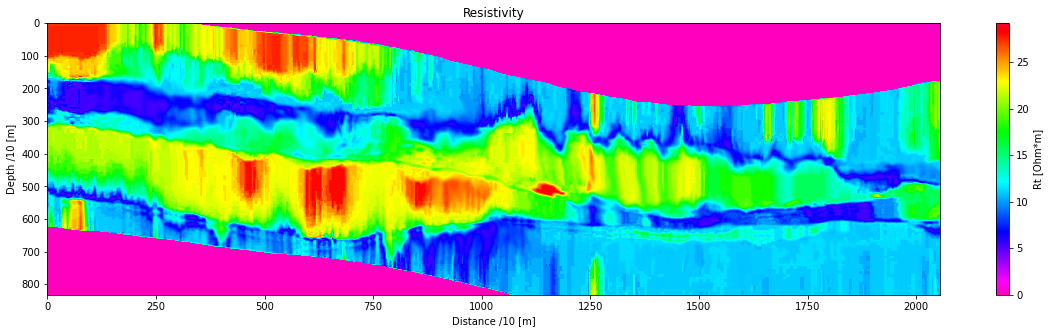

In [6]:
def plot(array, title = 'Resistivity', x_label = 'Distance /10 [m]', y_label = 'Depth /10 [m]', size = (20,5)):
  fig, ax = plt.subplots()
  fig.set_size_inches(size)
  plt.title(f'{title}')
  plt.xlabel(f'{x_label}')
  plt.ylabel(f'{y_label}')
  shw = ax.imshow(array, aspect='auto', interpolation = 'nearest', cmap = plt.get_cmap('gist_rainbow_r'))
  bar = plt.colorbar(shw)
  bar.set_label('Resistivity')
  bar.set_label('Rt [Ohm*m]')
plot(main_arr)


In [7]:
image_first_derivative = gaussian_filter(main_arr, sigma=20)

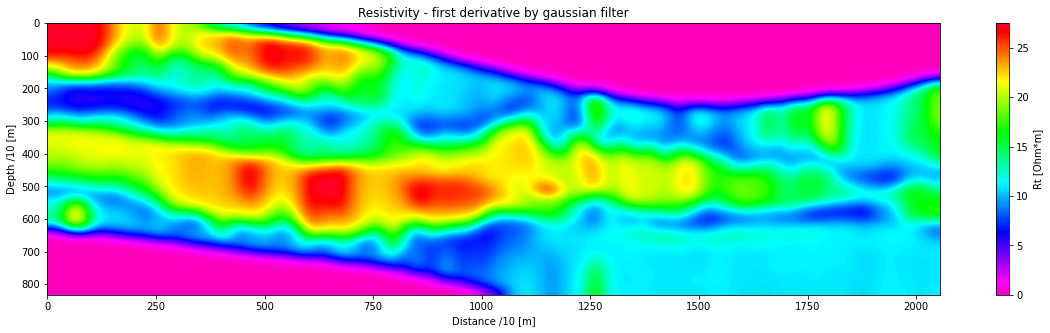

In [8]:
plot(image_first_derivative, title = 'Resistivity - first derivative by gaussian filter')

In [9]:
# import numpy as np
# from scipy.interpolate import griddata
# import matplotlib.pyplot as plt

# x = np.linspace(0,main_arr.shape[0],main_arr.shape[0]+1)
# y =  np.linspace(0,main_arr.shape[1],main_arr.shape[1]+1)
# X, Y = np.meshgrid(x,y)

# def f(x, y):
#     s = np.hypot(x, y)
#     phi = np.arctan2(y, x)
#     tau = s + s*(1-s)/5 * np.sin(6*phi) 
#     return 5*(1-tau) + tau

# T = f(X, Y)
# # Choose npts random point from the discrete domain of our model function
# npts = 400
# px, py = np.random.choice(x, npts), np.random.choice(y, npts)

# fig, ax = plt.subplots(nrows=2, ncols=2)
# # Plot the model function and the randomly selected sample points
# ax[0,0].contourf(X, Y, T)
# ax[0,0].scatter(px, py, c='k', alpha=0.2, marker='.')
# ax[0,0].set_title('Sample points on f(X,Y)')

# # Interpolate using three different methods and plot
# for i, method in enumerate(('nearest', 'linear', 'cubic')):
#     Ti = griddata((px, py), f(px,py), (X, Y), method=method)
#     r, c = (i+1) // 2, (i+1) % 2
#     ax[r,c].contourf(X, Y, Ti)
#     ax[r,c].set_title("method = '{}'".format(method))

# plt.tight_layout()
# plt.show()

In [10]:
for n in range (100):
    sampl_noize = np.random.uniform(low=n/(n**2+1), high=(n+2)/(n**2+1), size=(833, 2055))
    image_first_derivative+=sampl_noize
    sampl_noize = np.random.uniform(low=n/(n**2+1), high=(n+2)/(n**2+1), size=(833, 2055))
    image_first_derivative-=sampl_noize    
image_first_derivative = abs(image_first_derivative)

In [11]:
# a uniform (boxcar) filter with a width of 50
synth_section1 = ndimage.uniform_filter1d(image_first_derivative, 150, 0)

# a Gaussian filter with a standard deviation of 10
synth_section2 = ndimage.gaussian_filter1d(image_first_derivative, 90, 0)

In [12]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
synth_section1 = cv2.filter2D(src=synth_section1, ddepth=-25, kernel=kernel)
synth_section2 = cv2.filter2D(src=synth_section2, ddepth=-25, kernel=kernel)

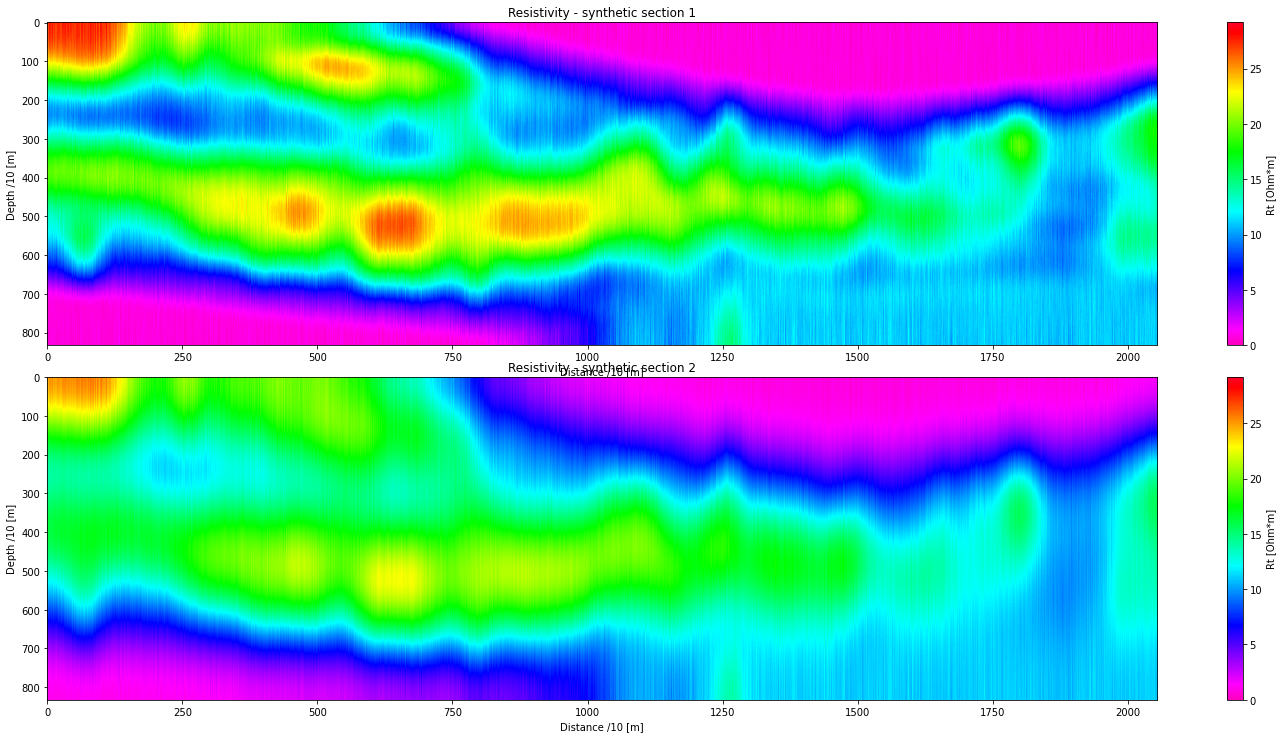

In [13]:
fig1, ax = plt.subplots(2,1)
fig1.set_size_inches(20,10)
plt.tight_layout()

ax[0].set_title('Resistivity - synthetic section 1')
ax[0].set_xlabel('Distance /10 [m]')
ax[0].set_ylabel('Depth /10 [m]')

                 
ss1 = ax[0].imshow(synth_section1, aspect='auto', 
                 interpolation = 'nearest', 
                 cmap = plt.get_cmap('gist_rainbow_r'),
                 vmin=np.min(main_arr), vmax=np.max(main_arr))
bar = plt.colorbar(ss1,ax=ax[0])
bar.set_label('Resistivity')
bar.set_label('Rt [Ohm*m]')



ax[1].set_title('Resistivity - synthetic section 2')
ax[1].set_xlabel('Distance /10 [m]')
ax[1].set_ylabel('Depth /10 [m]')

                 
ss1 = ax[1].imshow(synth_section2, aspect='auto', 
                 interpolation = 'nearest', 
                 cmap = plt.get_cmap('gist_rainbow_r'),
                 vmin=np.min(main_arr), vmax=np.max(main_arr))
bar = plt.colorbar(ss1,ax=ax[1])
bar.set_label('Resistivity')
bar.set_label('Rt [Ohm*m]')

In [14]:
synth_section1[None,:].shape

(1, 833, 2055)

In [15]:
empty_3d = np.empty([20,833,2055])
empty_3d[:] = np.nan

arr_3D = np.vstack([synth_section1[None,:], empty_3d])
arr_3D = np.vstack([arr_3D, main_arr[None,:]])
arr_3D = np.vstack([arr_3D, empty_3d])
arr_3D = np.vstack([arr_3D,synth_section2[None,:]])

In [16]:
arr_3D.shape

(43, 833, 2055)

Dirichlet interpolation requires even number of points. It is therefore advisable to interpolate left half and right half separately.

In [17]:
def swastika(x, y, nnew_ratio): #dirichlet interpolation intended for purely z-slices (with z being the dimension along which the data is generated)
  n = x.shape[0]
  nigger = np.fft.fft(y)
  jew = np.fft.fftfreq(x.shape[-1], 2 / n)
  nnew = n*nnew_ratio
  x_new = np.linspace(x[0], x[-1], nnew*2)
  nigger = np.concatenate([nigger, [np.conjugate(nigger[n//2])]]) #crutch
  jew = np.concatenate([jew, [-jew[n//2]]])
  hitler = np.array([np.dot(nigger, np.exp(jew * 2j * np.pi * xn) / n) for xn in x_new]) #convolution with the Dirichlet kernel in Fourier dual space
  return x_new, hitler

In [18]:
holocaust, holocaust1 = main_arr[10,10], synth_section1[10,10]

In [29]:
x = np.array([3])
y = np.array([main_arr[10,100]])

In [30]:
swastika(x,y, 2)

(array([3., 3., 3., 3.]),
 array([55.09573674+0.j, 55.09573674+0.j, 55.09573674+0.j, 55.09573674+0.j]))

(64,)


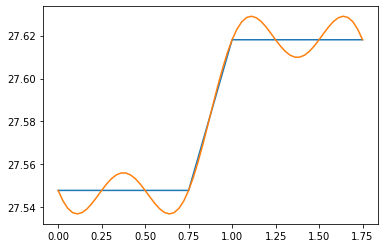

In [23]:
x = np.arange(8)/4
y = np.array([holocaust, holocaust, holocaust, holocaust, holocaust1, holocaust1, holocaust1, holocaust1])
x1, y1 = swastika(x,y,4)
print(y1.shape)
plt.plot(x, y)
plt.plot(x1, y1.real)

(8,)

In [22]:
volume = np.empty([0,43,833])


for n in range(len(arr_3D[0,0,:])):
# for n in range(6):
    array = arr_3D[:,:,n]
    x = np.arange(0, array.shape[1])
    y = np.arange(0, array.shape[0])
    #mask invalid values
    array = np.ma.masked_invalid(arr_3D[:,:,n])
    xx, yy = np.meshgrid(x, y)
    #get only the valid values
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]

    int_section = interpolate.griddata((x1, y1), newarr.ravel(),
                          (xx, yy),
                             method='cubic')
    volume = np.vstack([volume,int_section[None,:]])
    

KeyboardInterrupt: 

In [16]:
volume.shape

(2055, 43, 833)

In [17]:
volume = np.einsum('kli->lik', volume)
volume.shape

(43, 833, 2055)

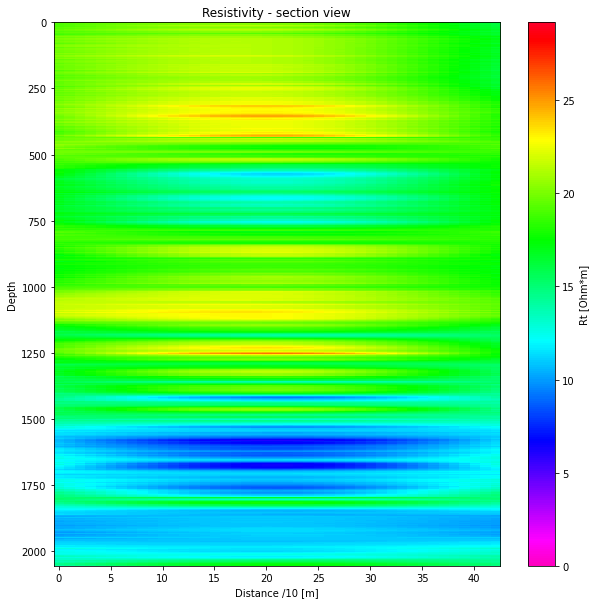

In [18]:
fig1, ax = plt.subplots()
fig1.set_size_inches(10,10)
plt.title('Resistivity - section view')
plt.xlabel('Distance /10 [m]')
plt.ylabel('Depth')
shw1 = ax.imshow(volume[:,400,:].T,
                 aspect='auto',
                 interpolation = 'nearest',
                 cmap = plt.get_cmap('gist_rainbow_r'),
                 vmin=np.min(main_arr), vmax=np.max(main_arr))
bar = plt.colorbar(shw1)
bar.set_label('Resistivity')
bar.set_label('Rt [Ohm*m]')

# Nonlinear interp

In [ ]:
main_arr.shape

(833, 2055)

In [ ]:
from scipy import interpolate

x = np.linspace(0, main_arr.shape[0],num = main_arr.shape[0])
y = np.linspace(0,main_arr.shape[1],num = main_arr.shape[1])
cubic = interpolate.interp2d(x,y,main_arr.T, kind = 'quintic')

main_arr_cubic = cubic(x,y)

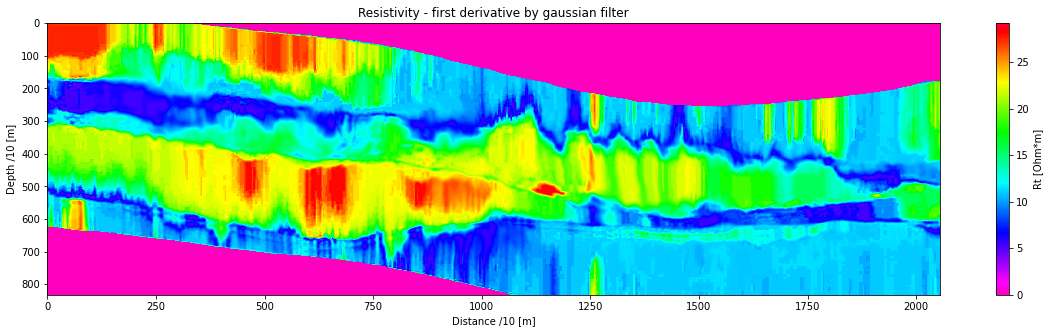

In [ ]:
fig1, ax = plt.subplots()
fig1.set_size_inches(20,5)
plt.title('Resistivity - first derivative by gaussian filter')
plt.xlabel('Distance /10 [m]')
plt.ylabel('Depth /10 [m]')
shw1 = ax.imshow(main_arr_cubic.T,
                 aspect='auto',
                 interpolation = 'nearest',
                 cmap = plt.get_cmap('gist_rainbow_r'),
                 vmin=np.min(main_arr_cubic), vmax=np.max(main_arr_cubic))
bar = plt.colorbar(shw1)
bar.set_label('Resistivity')
bar.set_label('Rt [Ohm*m]')

# 3D

In [ ]:
arr_3D = np.empty([0,833,2055])

for i in range(15):
  arr_3D = np.vstack([arr_3D, main_arr[None,:]])
print(arr_3D.shape)

(15, 833, 2055)


In [ ]:
arr_3D_cut = arr_3D[:1,:,:20]

In [ ]:
#%matplotlib notebook doesn't work in colab
fig = plt.figure()
fig.set_size_inches(20,20)
ax = fig.gca(projection='3d')

cmap = plt.get_cmap("hsv_r")
norm= plt.Normalize(arr_3D_cut.min(), arr_3D_cut.max())
ax.voxels(np.ones_like(arr_3D_cut), facecolors=cmap(norm(arr_3D_cut)))

plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>